<a href="https://colab.research.google.com/github/ParishaKB/COVID-19_lungscan/blob/main/Identification_of_COVID_19_using_lung_scan_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os

Importing data to train model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder="/content/drive/My Drive/covid"
images = []
ycovid = pd.DataFrame()
i = 0
for filename in os.listdir(folder):
  img = cv2.imread(os.path.join(folder,filename))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(320,320))
  img = np.reshape(img,(320*320))
  ycovid[i] = (0,1)
  i= i+1
  if img is not None:
    images.append(img)
    
images=np.asarray(images)
images.shape
xcovid = images

In [ ]:
folder="/content/drive/My Drive/non-covid"
images = []
ynocovid = pd.DataFrame()
i = 0
for filename in os.listdir(folder):
  img = cv2.imread(os.path.join(folder,filename))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img,(320,320))
  img = np.reshape(img,(320*320))
  ynocovid[i] = (1,0)
  i= i+1
  if img is not None:
    images.append(img)
    
images=np.asarray(images)
images.shape
xnocovid = images


In [ ]:
ynocovid = ynocovid.T
ycovid = ycovid.T

In [ ]:
frames = [pd.DataFrame(xcovid),pd.DataFrame(xnocovid)]
x= pd.concat(frames)

yframes = [ycovid,ynocovid]
y= pd.concat(yframes)


Function to show image 

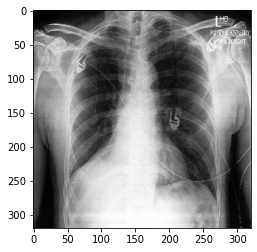

In [ ]:
plt.imshow(images[20].reshape(320,320),cmap=plt.cm.gray) 

Splitting data into test and train

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0)

In [ ]:
x_train, x_test = x_train/255., x_test/255.

PCA

In [ ]:
from sklearn import decomposition
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(150)
pca.fit_transform(x_train) #fitting the pixels into PCA to capture variability

array([[-1.53742408e+01, -1.84612095e+01,  6.81905868e+00, ...,
         1.01480673e+00,  6.63391976e-01,  1.41676990e-01],
       [ 7.99369332e+00, -5.88819971e+00,  4.44407041e+00, ...,
         5.81465903e-01, -9.09909237e-01, -1.49034605e+00],
       [-2.96796516e+00,  2.83714059e+00, -1.72674491e+01, ...,
         1.16352917e+00, -7.62843017e-01,  1.05610138e-02],
       ...,
       [ 5.27260757e+01,  4.26198851e+01,  1.23284802e+00, ...,
        -8.41136522e-02, -1.60421234e+00, -1.43388013e+00],
       [-2.03603374e+01,  6.11976929e+01, -1.45643842e+00, ...,
        -1.24731284e+00,  2.72731743e-01,  6.95232165e-01],
       [ 1.35010164e+01, -3.31306375e+01, -2.34813187e+01, ...,
        -4.29378688e-01,  1.01269117e-01, -4.31629124e+00]])

Checking the components required

In [ ]:
np.sum(pca.explained_variance_ratio_[:150])

0.979006732391036

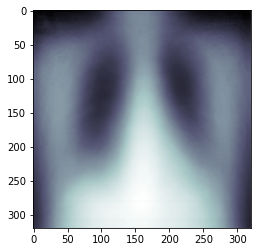

In [ ]:
plt.imshow(pca.mean_.reshape(320,320),      cmap=plt.cm.bone)

In [ ]:
newx_train = pca.fit_transform(x_train)
print(newx_train.shape)

(225, 150)


In [ ]:
newx_test = pca.transform(x_test)
print(newx_test.shape)

(75, 150)


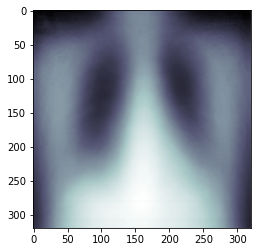

In [ ]:
plt.imshow(pca.mean_.reshape(320,320),cmap=plt.cm.bone)

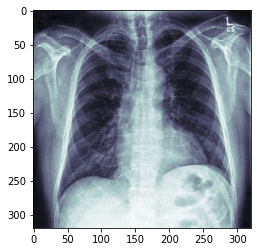

In [ ]:
#projected face
inv_proj3 = pca.inverse_transform(newx_train)
plt.imshow(inv_proj3[99].reshape(320,320),cmap=plt.cm.bone)

In [ ]:
newx_train = pd.DataFrame(newx_train)
newx_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,-15.374241,-18.461209,6.819059,-12.094163,-7.335470,-1.710492,18.553380,-4.823941,-6.598300,-8.706331,-2.951412,1.411513,-7.774175,1.126080,3.659556,5.350727,7.286156,7.181257,2.532275,2.075972,-6.868394,-4.864118,8.753484,2.495092,-1.577449,9.346649,3.042958,0.829731,-6.872917,-7.814040,2.241721,-2.165940,-0.929534,1.103868,-3.473801,-6.476160,3.167988,4.341830,-0.825932,-3.943353,...,0.786753,2.785394,2.313039,3.479221,2.447244,-1.605250,2.042910,1.446056,5.683056,0.238015,1.548883,3.213063,-2.928857,3.905297,-2.808184,2.558166,0.788381,-2.745520,-1.509492,0.938727,-0.744702,0.143383,-0.222108,2.591952,-1.817316,0.988969,-3.139630,-1.155839,0.901833,-1.197428,-1.156796,2.487229,-3.879247,-0.013373,0.948188,0.256785,-0.735484,0.083559,-0.836658,-0.947182
1,7.993693,-5.888200,4.444070,-7.425651,10.341545,5.617300,2.278202,3.821537,-3.086003,-0.555937,-5.903408,-2.396290,6.979010,-7.720637,5.182374,-1.632106,-1.195458,-1.044154,6.467113,0.488439,4.368495,3.909812,-4.075254,-0.492028,-3.292162,-6.723967,-0.118851,-0.144142,1.955250,-1.436673,-0.828418,1.154489,1.896194,-0.534031,0.232138,1.257023,-0.841309,1.173743,1.062389,-0.019319,...,-1.368888,-1.156119,0.672924,0.384522,1.586727,-0.183696,-0.493174,-1.691927,-0.330080,-0.820063,2.098453,0.305374,-0.954959,-0.867096,-0.387254,0.161527,-1.633277,-0.562991,-0.029442,-0.245689,1.761531,0.549837,0.344870,0.191687,-1.123755,-0.343287,-0.949135,0.427335,-0.625183,-2.270088,-0.433406,-0.986682,-0.544510,0.199899,2.262273,0.671058,-0.829036,-0.290299,1.007214,-0.462696
2,-2.967965,2.837141,-17.267449,12.203732,11.365007,14.766477,-10.635820,1.017962,-4.790398,-5.976901,-1.017142,-2.880363,1.740055,-6.250136,-2.863101,-4.500452,-0.534642,-2.571456,-1.071312,-0.714780,2.918402,-4.121284,0.776515,2.098731,-2.512324,1.612112,-1.659063,-1.258528,-1.753468,-1.748567,0.505259,-1.438692,0.999824,1.171073,0.521395,0.437259,-0.897590,2.394809,-1.130111,0.621250,...,0.603801,-0.742096,-1.044177,0.794593,0.715936,0.905290,0.120071,-0.405434,0.128186,-0.218130,1.554857,0.408748,-0.746960,0.630369,-1.649657,1.383767,0.493593,-0.456609,-0.158923,0.068799,0.685308,0.882113,-0.627708,-0.896140,-0.363085,-0.147785,-1.387330,0.384086,-0.460792,-0.337860,-0.174972,1.238307,0.250486,-0.026259,-1.620112,-0.309145,-1.264593,0.037606,0.803437,0.137466
3,-18.959398,-11.969740,26.054547,-22.863649,1.212714,4.830973,-2.387752,10.801278,1.600382,11.063783,-4.922023,-4.897941,8.453868,0.432832,3.471346,-4.703384,-1.095760,-9.741597,-5.143433,-3.901110,4.998660,-11.212100,4.447729,-2.112041,5.148038,-0.116142,1.086180,5.963776,-1.771930,-1.010881,4.181213,-7.274557,-0.800637,-3.327121,1.328250,4.993547,1.970431,0.566348,1.070903,5.255271,...,-0.603171,-0.491128,-3.118007,-0.606232,4.186689,-0.099408,-1.202269,4.599964,0.520124,-0.493539,-3.485435,-2.200318,-0.707494,4.220645,-0.879632,-1.413185,0.763998,-2.057707,-0.067968,1.432571,0.318880,-0.622883,0.949865,1.308694,-3.508889,-0.856306,-3.692179,0.912967,0.643832,1.639874,-0.004132,-1.076446,1.536827,2.047884,1.216763,-0.279414,0.832145,-1.064033,-3.133286,0.822687
4,-5.040490,4.295324,26.619688,-31.387751,12.326407,-26.747849,-7.053840,-5.705441,-12.529091,-1.504257,0.901782,3.533689,1.113134,5.642743,-1.394993,12.090527,8.458714,0.407020,-7.580938,4.795240,-3.894187,-2.425299,-0.031580,8.066790,-3.052151,4.314184,-1.436735,-1.971939,5.677985,5.926463,-2.021482,3.815422,-5.129736,-1.051159,-0.600364,3.279384,2.057144,-1.932019,-0.684433,1.259247,...,-0.224830,1.810312,-2.297650,-0.183905,1.413297,0.826750,0.536756,-0.573159,0.473816,0.825066,-1.573760,-0.834009,-0.061779,2.727082,1.299914,1.303015,1.262311,0.218615,-0.112201,-0.043941,0.347039,-2.583085,-3.039454,0.058714,1.885318,-1.937

In [ ]:
y_train.head()

,0,1
109,1,0
37,0,1
97,0,1
41,1,0
135,0,1


In [ ]:
y_train=y_train.iloc[:,-1]
y_test=y_test.iloc[:,-1]

In [ ]:
y_train.head()

109    0
37     1
97     1
41     0
135    1
Name: 1, dtype: int64

In [ ]:
from keras import models
from keras import layers

In [ ]:
nn=models.Sequential()

In [ ]:
nn.add(layers.Dense(2048,activation = "relu",input_shape=(150,))) 
nn.add(layers.Dense(1024,activation='relu'))
nn.add(layers.Dense(512,activation='relu'))
nn.add(layers.Dense(256,activation='tanh'))
nn.add(layers.Dense(256,activation='relu'))
nn.add(layers.Dense(128,activation='relu'))
nn.add(layers.Dense(1,activation='sigmoid'))

In [ ]:
nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              309248    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [ ]:
nn.compile(optimizer='rmsprop',
           loss='binary_crossentropy',
           metrics=['accuracy'])

In [ ]:
nn.fit(newx_train,y_train,epochs=50,batch_size=120)

Epoch 1/50
2/2 [==============================] - 0s 8ms/step - loss: 0.7623 - accuracy: 0.4756
Epoch 2/50
2/2 [==============================] - 0s 5ms/step - loss: 1.6543 - accuracy: 0.4933
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.7488 - accuracy: 0.5600
Epoch 4/50
2/2 [==============================] - 0s 4ms/step - loss: 0.6171 - accuracy: 0.6578
Epoch 5/50
2/2 [==============================] - 0s 4ms/step - loss: 0.4100 - accuracy: 0.8756
Epoch 6/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2350 - accuracy: 0.9333
Epoch 7/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2382 - accuracy: 0.9289
Epoch 8/50
2/2 [==============================] - 0s 5ms/step - loss: 0.1626 - accuracy: 0.9422
Epoch 9/50
2/2 [==============================] - 0s 4ms/step - loss: 0.0446 - accuracy: 0.9911
Epoch 10/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0306 - accuracy: 1.0000
Epoch 11/50
2/2 [======================

In [ ]:
test_loss,test_accuracy = nn.evaluate(newx_test,y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.6853 - accuracy: 0.9067


In [ ]:
test_loss

0.685285210609436

In [ ]:
test_accuracy

0.9066666960716248